This notebook demonstrates one example of analzying a large incomplete dataset and using machine learning to predict SAT scores based on various features.

The general sequence will involve:
- Problem Definition
- Data acquisition
- Analysis of data
- Data Wrangling
- Modelling and Predicting
- Present Solution.

This notebook will demonstrate the notion that this sequence is not rigid and may require combinations of various stages. For example, we will perform a preliminary analysis of the data and concurrently correct or complete various features as necessary to ease the analysis procedure. Furthermore, we may wish to perform further anaylsis once we have a complete dataset after the data wrangling stage.

# Problem Definition
In this instance, we will be examining the 2012 SAT scores from various schools with the NY state. We would like to determine if we can predict the SAT results based on various features. Since we do not have testing data, we will separate the dataset into two segments (training data and testing data).

# Acquire Data
### Import relevant libaries and dataset.

In [621]:
#Libraries for data wrangling
import pandas as pd
import numpy as np
import scipy as sp
import time
import math

#Libraries for data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from pandas.plotting import scatter_matrix
from pandas.plotting import parallel_coordinates

#Libraries for machine learning
from sklearn import model_selection

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#Read in SAT Scores dataset
df = pd.read_csv('scores.csv')

# Analyze Dataset
## 1. Describe Data

First we will examine what features are included, their type and the number of entries within each feature.

In [622]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 22 columns):
School ID                      435 non-null object
School Name                    435 non-null object
Borough                        435 non-null object
Building Code                  435 non-null object
Street Address                 435 non-null object
City                           435 non-null object
State                          435 non-null object
Zip Code                       435 non-null int64
Latitude                       435 non-null float64
Longitude                      435 non-null float64
Phone Number                   435 non-null object
Start Time                     431 non-null object
End Time                       431 non-null object
Student Enrollment             428 non-null float64
Percent White                  428 non-null object
Percent Black                  428 non-null object
Percent Hispanic               428 non-null object
Percent Asian             

Take note of the various incomplete features. For example, whilst there are 435 School entries, there are only 428 entries within the Ethnicity features and 375 entires for Average SAT Scores.

In [623]:
df.head(5)

,School ID,School Name,Borough,Building Code,Street Address,City,State,Zip Code,Latitude,Longitude,...,End Time,Student Enrollment,Percent White,Percent Black,Percent Hispanic,Percent Asian,Average Score (SAT Math),Average Score (SAT Reading),Average Score (SAT Writing),Percent Tested
0,02M260,Clinton School Writers and Artists,Manhattan,M933,425 West 33rd Street,Manhattan,NY,10001,40.75321,-73.99786,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06M211,Inwood Early College for Health and Informatio...,Manhattan,M052,650 Academy Street,Manhattan,NY,10002,40.86605,-73.92486,...,3:00 PM,87.0,3.4%,21.8%,67.8%,4.6%,NaN,NaN,NaN,NaN
2,01M539,"New Explorations into Science, Technology and ...",Manhattan,M022,111 Columbia Street,Manhattan,NY,10002,40.71873,-73.97943,...,4:00 PM,1735.0,28.6%,13.3%,18.0%,38.5%,657.0,601.0,601.0,91.0%
3,02M294,Essex Street Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,...,2:45 PM,358.0,11.7%,38.5%,41.3%,5.9%,395.0,411.0,387.0,78.9%
4,02M308,Lower Manhattan Arts Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,...,3:00 PM,383.0,3.1%,28.2%,56.9%,8.6%,418.0,428.0,415.0,65.1%


We now gain further insight into what the dataset looks like.

<b>Categorical Features</b><br>
Features that can be grouped into similar samples. We should determine which of these features are nominal, ordinal or interval specific.
- Location Features (Borough, City, State, Zip Code)

<b>Numerical Features</b><br>
Features that have numerical values. We should determine which of these features are discrete, continuous or follow a time series.
- Student Enrollment
- Ethnicity Features (White, Black, Hispanic, Asian)
- Average SAT Score Features (Math, Reading, Writing)
- Location Features (Latitude, Longitude)

<b>Mixed Data Type Features</b><br>
Features that include numbers and letters. These types of features are often prone to errors involving misspelling etc.
- School ID
- Building Code
- Street Address
- Time Features (Start, End)
- Ethnicity Features (White, Black, Hispanic, Asian)
- Percentage Tested

Note that these last three Mixed Data Type Features are indicative of numerical features. We should remember to correct their type in the following stage.

## 2. Identify features that contain empty values (NaN) or errors

In [624]:
df.isnull().sum()

School ID                       0
School Name                     0
Borough                         0
Building Code                   0
Street Address                  0
City                            0
State                           0
Zip Code                        0
Latitude                        0
Longitude                       0
Phone Number                    0
Start Time                      4
End Time                        4
Student Enrollment              7
Percent White                   7
Percent Black                   7
Percent Hispanic                7
Percent Asian                   7
Average Score (SAT Math)       60
Average Score (SAT Reading)    60
Average Score (SAT Writing)    60
Percent Tested                 49
dtype: int64

Notice that data is missing for Start and End Times, Ethnicity Features, SAT Score features and the Percent Tested feature. We will complete these missing entries later on.

## 3. Describe Numerical Features
This will provide an initial insight into the numerical features and how well they represent the domain being investigated.

In [625]:
df.describe()

,Zip Code,Latitude,Longitude,Student Enrollment,Average Score (SAT Math),Average Score (SAT Reading),Average Score (SAT Writing)
count,435.000000,435.000000,435.000000,428.000000,375.000000,375.000000,375.000000
mean,10726.096552,40.745472,-73.921072,702.357477,432.944000,424.504000,418.458667
std,537.927907,0.080937,0.071705,759.176061,71.952373,61.881069,64.548599
min,10001.000000,40.528230,-74.192150,62.000000,317.000000,302.000000,284.000000
25%,10301.500000,40.690495,-73.979260,357.250000,386.000000,386.000000,382.000000
50%,10472.000000,40.741210,-73.925140,466.000000,415.000000,413.000000,403.000000
75%,11217.000000,40.822095,-73.882580,623.250000,458.500000,445.000000,437.500000
max,11694.000000,40.888370,-73.726910,5447.000000,754.000000,697.000000,693.000000


Before we continue, it should be noted that the Ethnicity features and Percent Tested feature have not been included here as they are currently identified as objects. By viewing the dataset earlier, we became aware that these feautures are in fact numerical by nature. At this stage, I am therefore inclined to convert these features to a float type in order to include these features within this section where we describe numerical features.

In [626]:
numerical_features=['Percent White','Percent Black','Percent Hispanic','Percent Asian','Percent Tested']
for col in numerical_features:
    df.loc[df[col].notnull(),col]=df.loc[df[col].notnull(),col].str.replace('%','').astype(float)/100
    df[col]=df[col].astype(float)

In [627]:
df.describe()

,Zip Code,Latitude,Longitude,Student Enrollment,Percent White,Percent Black,Percent Hispanic,Percent Asian,Average Score (SAT Math),Average Score (SAT Reading),Average Score (SAT Writing),Percent Tested
count,435.000000,435.000000,435.000000,428.000000,428.000000,428.000000,428.000000,428.000000,375.000000,375.000000,375.000000,386.000000
mean,10726.096552,40.745472,-73.921072,702.357477,0.083107,0.353072,0.443124,0.101657,432.944000,424.504000,418.458667,0.633472
std,537.927907,0.080937,0.071705,759.176061,0.128321,0.250037,0.242919,0.139679,71.952373,61.881069,64.548599,0.205423
min,10001.000000,40.528230,-74.192150,62.000000,0.000000,0.000000,0.026000,0.000000,317.000000,302.000000,284.000000,0.000000
25%,10301.500000,40.690495,-73.979260,357.250000,0.013000,0.171000,0.217750,0.016000,386.000000,386.000000,382.000000,0.492750
50%,10472.000000,40.741210,-73.925140,466.000000,0.026500,0.286500,0.455500,0.042500,415.000000,413.000000,403.000000,0.633000
75%,11217.000000,40.822095,-73.882580,623.250000,0.090000,0.481500,0.634250,0.113750,458.500000,445.000000,437.500000,0.789000
max,11694.000000,40.888370,-73.726910,5447.000000,0.799000,0.941000,1.000000,0.889000,754.000000,697.000000,693.000000,1.000000


We can now view all the relevant numerical features to describe. 
### a. Zip Code
All zip code values lie within the range of 10001 to 11694. At first glance, the feature appears to be complete and correct - all values are integers and lie within the NY State range of [10001,11697].

### b. Latitude and Longitude
There appear to be no erroneous values within these features as they all fall within the NY State coordinate range. Additionally, the feature appears to be complete with 435 entries. See the figure below with plots of min, mean and max longitude and latitude locations in the NY State area.<br>
<img src="./images/NY_map.jpg" alt="Drawing" style="width: 800px;"/>

### c. Student Enrollment
The Student Enrollment feature does contain some missing values however the remaining set appears to represent a suitable distribution of the number of students enrolled in each NY school. 

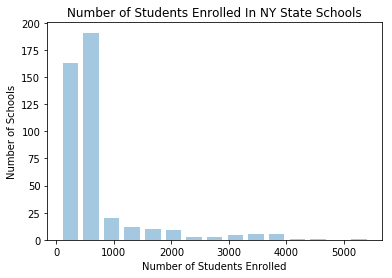

In [628]:
st_enrol=df['Student Enrollment'].dropna()
g=sns.distplot(st_enrol, bins=15, kde=False,
             hist_kws={"rwidth":0.75})      
g.set_ylabel('Number of Schools')
g.set_xlabel('Number of Students Enrolled')
g.axes.set_title('Number of Students Enrolled In NY State Schools', fontsize=12,alpha=1)
plt.show()

In the above graph we can visualize the range of students enrolled in various schools across the NY State. It can be observed that majority of the schools contain [0-500] or [500-100] students.<br><br>
<b>Note:</b> The 7 missing values in the Student Enrollment feature have been excluded from this graph. These values will be addressed in the data wrangling stage.

### d. Ethnicity Features
Ethnicity feature distribution between schools

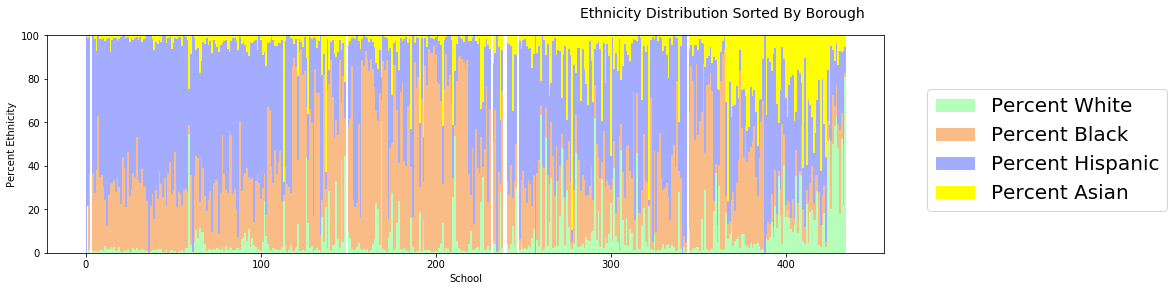

In [629]:
def ethnicity_graph(data,sort_name):
    totals = [i+j+k+l for i,j,k,l in zip(data['Percent White'], data['Percent Black'], data['Percent Hispanic'],data['Percent Asian'])]
    greenBars = [i / j * 100 for i,j in zip(data['Percent White'], totals)]
    orangeBars = [i / j * 100 for i,j in zip(data['Percent Black'], totals)]
    blueBars = [i / j * 100 for i,j in zip(data['Percent Hispanic'], totals)]
    yellowBars = [i / j * 100 for i,j in zip(data['Percent Asian'], totals)]
 
    fig=plt.figure(figsize=(25,4))
    ax = plt.subplot(111)

    # plot
    barWidth = 1.0
    names = r
    plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth,label='Percent White')
    plt.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth,label='Percent Black')
    plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='#a3acff', edgecolor='white', width=barWidth,label='Percent Hispanic')
    plt.bar(r, yellowBars, bottom=[i+j+k for i,j,k in zip(greenBars, orangeBars,blueBars)], color='yellow', edgecolor='white', width=barWidth,label='Percent Asian')

    #Label axis
    #plt.xticks(r, names)
    plt.xlabel("School") 
    plt.ylabel("Percent Ethnicity") 

    #Add Legend
    chartBox = ax.get_position()
    ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
    ax.legend(loc='upper right',fontsize=20,bbox_to_anchor=(1.35, 0.8))
    plt.suptitle('Ethnicity Distribution Sorted By '+str(sort_name),fontsize=14)
    plt.show()

# Data
r = range(0,len(df.count(axis=1)))
ethnicity_series=['Percent White','Percent Black','Percent Hispanic','Percent Asian']

#Sort Distribution Graph by Feature
sort_name='Borough'
data = df.sort_values(by=sort_name, ascending=True).loc[:,ethnicity_series].copy()*100

ethnicity_graph(data,sort_name)

The above graph highlights the distribution of ethnicity groups across all schools in the NY state. We have also sorted this distribution by Borough in order to gain further insight into the distribution of ethnicities within each borough. From the above, it becomes somewhat clear that each borough has it's own unique distribution of ethnicities. For example, the first 100 schools show a large percentage of students with hispanic and black ethnicities in the first borough. Similarly, the last 100 schools detail a larger portion of asian students within the last borough in comparison to the other boroughs.<br><br>
Another more elegant way of understanding the distribution of ethnicities in schools between boroughs is by pivotting Borough with Ethnicity features and creating a parallel plot.

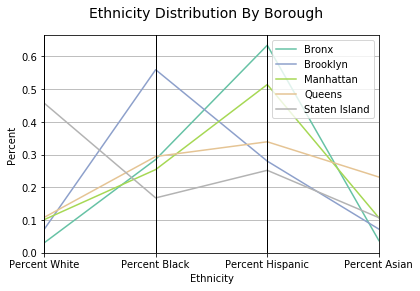

In [630]:
pivot_feature='Borough'
data=df[[pivot_feature, 'Percent White','Percent Black','Percent Hispanic',
         'Percent Asian']].groupby([pivot_feature], as_index=False).mean()

parallel_coordinates(data, pivot_feature, colormap=plt.get_cmap("Set2"))
plt.xlabel("Ethnicity") 
plt.ylabel("Percent") 
plt.suptitle('Ethnicity Distribution By '+str(pivot_feature),fontsize=14)
plt.show()

The graph further illustrates the ethnicity distrubtion in schools between boroughs.
### e. Average SAT Score Features
We will now analyze the SAT scores for each subject. Following on from the above pivot with the Borough feature, we will investigate the spread of scores between each borough.

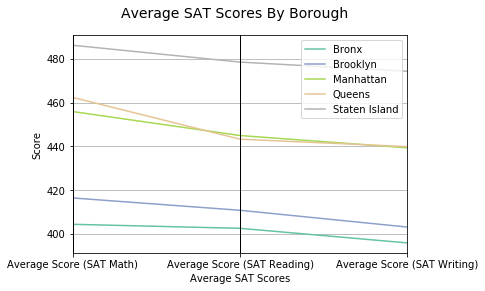

In [631]:
pivot_feature='Borough'
data=df[[pivot_feature, 'Average Score (SAT Math)', 'Average Score (SAT Reading)', 
         'Average Score (SAT Writing)']].groupby([pivot_feature], as_index=False).mean()

parallel_coordinates(data, pivot_feature, colormap=plt.get_cmap("Set2"))
plt.xlabel("Average SAT Scores") 
plt.ylabel("Score") 
plt.suptitle('Average SAT Scores By '+str(pivot_feature),fontsize=14)
plt.show()

Whilst you may immediately be drawn to the conclusion that Staten Island is the highest performing borough, it is important to note the number of schools that are considered within each borough.

In [632]:
df['Borough'].value_counts()

Brooklyn         121
Bronx            118
Manhattan        106
Queens            80
Staten Island     10
Name: Borough, dtype: int64

Upon further investigation we can see that there are only 10 schools in Staten Island being considered. This small sample size causes a decrease in diversity when pivoting features against Borough. Thus, there may be a bias causing the high mean Average SAT scores.

A boxplot is a great way to understand the shape of the SAT score distributions as well as their central value and variability. A jitter effect has been included to assist with visualizing the spread of scores within each group.

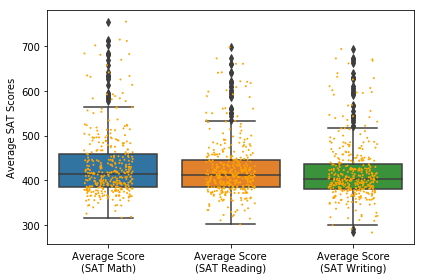

In [633]:
a = pd.DataFrame({ 'key' : np.repeat('Average Score (SAT Math)',df['Average Score (SAT Math)'].dropna().count()), 'value': df['Average Score (SAT Math)'].dropna() })
b = pd.DataFrame({ 'key' : np.repeat('Average Score (SAT Reading)',df['Average Score (SAT Reading)'].dropna().count()), 'value': df['Average Score (SAT Reading)'].dropna()})
c = pd.DataFrame({ 'key' : np.repeat('Average Score (SAT Writing)',df['Average Score (SAT Writing)'].dropna().count()), 'value': df['Average Score (SAT Writing)'].dropna()})
df_box=a.append(b).append(c)
ax = sns.boxplot(x='key', y='value', data=df_box)
ax = sns.stripplot(x='key', y='value', data=df_box, color="orange", jitter=0.2, size=2)

columns=['Average Score (SAT Math)', 'Average Score (SAT Reading)', 'Average Score (SAT Writing)',]
columns = ["\n".join(textwrap.wrap(i,16)) for i in columns]
ax.set_xticklabels(columns,rotation=0,ha="center",rotation_mode='anchor')
ax.set_ylabel('Average SAT Scores')    
ax.set_xlabel('')
plt.tight_layout()
plt.show()

It can be observed that the median of all three subjects appear to be similar.<br><br>
The SAT Math third quartile appears to be noticeably higher than the other two subjects.<br><br>
Another efficient way to identify SAT score trends is to create a new feature, which groups the subjects together into a total SAT score. However, we should only do so once the incomplete SAT Scores for Math, Reading and Writing are completed.

### f. Percent Tested
We will look at the correlation between percent tested and other features later on once we have completed the missing values in this feature.

## Categorical Features

In [634]:
df.describe(include=['O'])

,School ID,School Name,Borough,Building Code,Street Address,City,State,Phone Number,Start Time,End Time
count,435,435,435,435,435,435,435,435,431,431
unique,435,435,5,256,256,27,1,427,38,59
top,29Q243,Academy of Innovative Technology,Brooklyn,X450,800 East Gun Hill Road,Brooklyn,NY,718-381-7100,8:00 AM,3:00 PM
freq,1,1,121,6,6,121,435,4,152,81


After investigating the categorical features, it can be seen that the <b>School ID</b> and <b>School Name</b> features all have a complete set of unique values as one would expect. The geographic features <b>(Borough, City, State)</b> show a smaller set unique values (Borough:5, City:27, State:1), which correspond to the New York State information.

It is interesting to note however, that the <b>Building Code</b> and <b>Street Address</b> features show 256 unique values (out of 435), which may suggest that numerous unique schools are located at the same campus. As geographic location may play an important role on expected average SAT Scores, this discovery may be of use later on.

Additionally, it can be seen that the <b>Phone Number</b> feature shows 427 unique values (out of 435), which suggests that multiple schools share the same phone number. We can investigate which schools have similar phone numbers below.

In [635]:
pd.concat(dup for _, dup in df[['School Name','Street Address',
                                'Phone Number']].groupby('Phone Number') if len(dup) > 1)

,School Name,Street Address,Phone Number
96,High School for Media and Communications,549 Audubon Avenue,212-927-1841
97,College Academy,549 Audubon Avenue,212-927-1841
100,High School for Health Careers and Sciences,549 Audubon Avenue,212-927-1841
368,Brooklyn School for Math and Research,400 Irving Avenue,718-381-7100
369,Bushwick School for Social Justice,400 Irving Avenue,718-381-7100
370,Academy for Environmental Leadership,400 Irving Avenue,718-381-7100
371,Academy of Urban Planning,400 Irving Avenue,718-381-7100
300,"High School for Enterprise, Business, and Tech...",850 Grand Street,718-387-2800
303,School for Legal Studies,850 Grand Street,718-387-2800
151,New Directions Secondary School,240 East 172nd Street,718-410-4242


The above subset illustrates the schools that share the same phone numbers. For example, there are several schools located at 400 Irving Avenue, Brooklyn that share the same phone number. This notion may prove interesting when determining relationships between school location and SAT Scores.

### a. Distribution of Schools within Borough and City

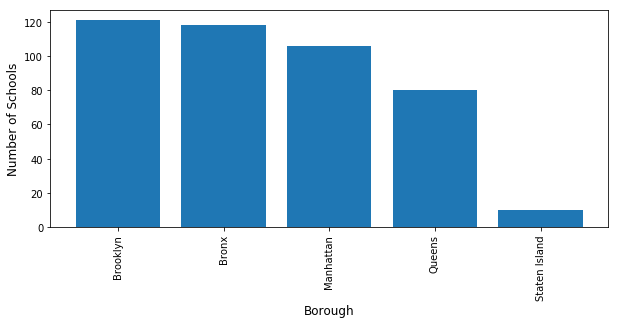

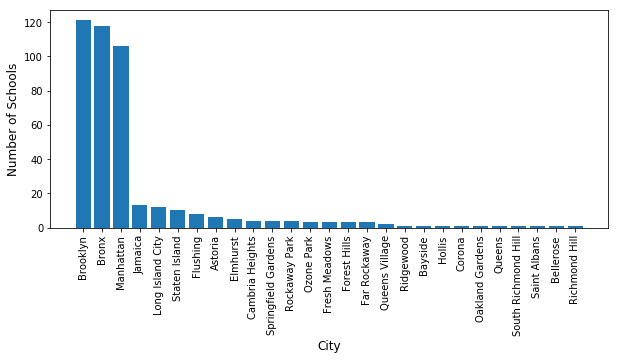

In [636]:
for col in ['Borough','City']:
    plt.figure(figsize=(10,4))
    height = df[col].value_counts()
    bars = height.index
    y_pos = np.arange(len(bars))
    plt.bar(y_pos, height)
    plt.xticks(y_pos, bars,rotation='vertical')
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Number of Schools', fontsize=12)
    plt.show()

Previously we addressed the fact that there does not appear to be an even split of schools between boroughs. For example, Staten Island only has 10 schools within its borough. Extending this notion to the City feature and we can notice that Brooklyn, Bronx and Manhattan cities contain far more schools than the remaining cities. Therefore, we should be cautious to use the City feature for predictive modelling as there is clearly a bias with the Cities containing small sample sets.

### b. Start and End Times
In order to analyze the Start and End Time data, we need to convert these object types (representing a time-series) into a format that is easy to visualize. One such way is to rank the start and end times.

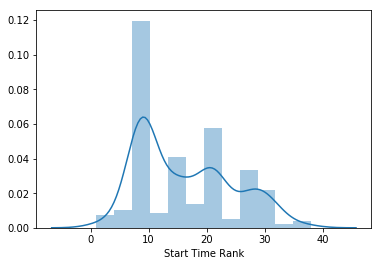

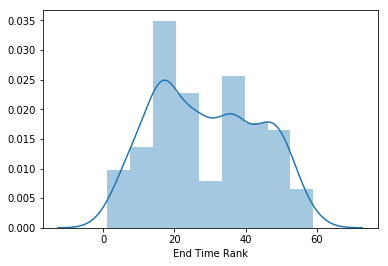

In [637]:
df['Start Time Rank'] = pd.to_datetime(df["Start Time"]).rank(method="dense")
df['End Time Rank'] = pd.to_datetime(df["End Time"]).rank(method="dense")
sns.distplot( df["Start Time Rank"].dropna() )
plt.show()
sns.distplot( df["End Time Rank"].dropna() )

# Wrangle Data

We have just completed our preliminary analysis of the dataset. Whilst there were some data wrangling methods applied, we will now complete, clean and correct the remaining features. 
Let's re-examine the incomplete features and discuss imputation methods and implications.

In [638]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 24 columns):
School ID                      435 non-null object
School Name                    435 non-null object
Borough                        435 non-null object
Building Code                  435 non-null object
Street Address                 435 non-null object
City                           435 non-null object
State                          435 non-null object
Zip Code                       435 non-null int64
Latitude                       435 non-null float64
Longitude                      435 non-null float64
Phone Number                   435 non-null object
Start Time                     431 non-null object
End Time                       431 non-null object
Student Enrollment             428 non-null float64
Percent White                  428 non-null float64
Percent Black                  428 non-null float64
Percent Hispanic               428 non-null float64
Percent Asian          

## Dropping Features
At this stage we want to correct the dataset by dropping any irrelevant features. You will note that we have already corrected the Ethnicity features by converting the data type from object to float to accurately represent the percentage values for each feature.
1. School ID may be dropped as this feature does not contribute to the SAT Scores.
2. School Name is a non-standard feature and may not contribute directly to the SAT Scores.
3. Street Address may contribute to SAT scores, however for the purposes of this exercise we will rely on other geographical features.
4. Latitude and Longitude Features could be further engineered into geographical bands, however for this excercise we will rely on the remaining geographical features, namely Borough, City and Zip Code.
5. Building Code may be dropped as this mixed data type feature does not contribute to the SAT Scores.
6. State may be dropped as this feature only contains one value, NY.
7. Phone Number may be dropped as this feature does not contribute to the SAT Scores.
8. Start and End Time features have been converted into Start and End Time Rank features and thus may be dropped at this point.

In [639]:
df=df.drop(['School ID','School Name','Street Address','Building Code','Latitude','Longitude','State',
            'Phone Number','Start Time','End Time'],axis=1)

## Converting Features
### Converting Numerical Features

### 1. Ethnicity Feature
We previously converted the ethnicity features from objects to floats. However, we will also need to complete the missing values, which we will do further on in the Completing Features section.

### 2. Time Features
In order to perform machine learning applications on the dataset, the features cannot be in string or object forms. Hence, we converted these times into a rank from the earliest to latest start and end time.

We have also dropped the Start and End Time Features


### 3. Percent Tested

Percent Tested feature has also been converted to a float type in order to facilitate the modelling stage.

### Converting Categorical Features
We now need to convert categorical features to numerical formatting to assist with our predictive modelling.
### 1. Borough & City

In [640]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["Borough Label"] = lb_make.fit_transform(df["Borough"])
df["City Label"] = lb_make.fit_transform(df["City"])
df=df.drop('Borough',axis=1)
df=df.drop('City',axis=1)

## Completing Features
### Numerical (Continuous) Features

Now we should start estimating and completing features with missing or null values. We will first do this for the Age feature.

We can consider three methods to complete a numerical continuous feature.

There are various ways to complete features with missing values
- Generate a random number between mean and standard deviation.
- Utilize a correlation between other features. For example, missing Start Time values can be filled using the mean Start Time among each city. 
- A comination of the above. For example, using random numbers between mean and standard deviation, based on correlated features.

It should be noted however that using random numbers may include random noise within the various models. In light of this, we will opt for the statistically safer option of imputing with feature means.

In [641]:
df.isnull().sum()

Zip Code                        0
Student Enrollment              7
Percent White                   7
Percent Black                   7
Percent Hispanic                7
Percent Asian                   7
Average Score (SAT Math)       60
Average Score (SAT Reading)    60
Average Score (SAT Writing)    60
Percent Tested                 49
Start Time Rank                 4
End Time Rank                   4
Borough Label                   0
City Label                      0
dtype: int64

In [642]:
impute_features=['Student Enrollment','Percent White','Percent Black','Percent Hispanic','Percent Asian',
                 'Average Score (SAT Math)','Average Score (SAT Reading)','Average Score (SAT Writing)',
                'Start Time Rank', 'End Time Rank','Percent Tested']
for col in impute_features:
    df[col]=df[col].fillna(df[col].mean())

## Create New Features
As mentioned earlier, a nice way of analyzing SAT Score trends is to create a new feature that is the sum of the 3 SAT subjects.

count     435.000000
mean     1275.906667
std       180.932580
min       924.000000
25%      1161.000000
50%      1255.000000
75%      1313.000000
max      2144.000000
Name: Average Score (SAT Total), dtype: float64


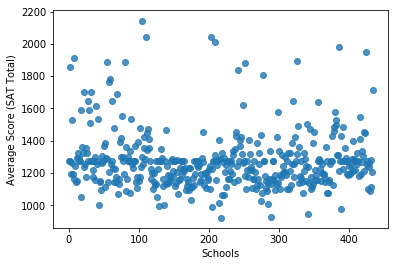

In [643]:
df['Average Score (SAT Total)']=df[['Average Score (SAT Math)','Average Score (SAT Reading)','Average Score (SAT Writing)']].sum(axis=1)
print(df['Average Score (SAT Total)'].describe())

ax=sns.regplot(x=pd.Series(np.arange(0,df['Average Score (SAT Total)'].dropna().count())), y=df['Average Score (SAT Total)'].dropna(), fit_reg=False)
ax.set(xlabel='Schools', ylabel='Average Score (SAT Total)')
plt.show()

# Correlating

At this stage we will determine how well each feature correlates with the various Average SAT scores. We can also pivot features against each other. Not only does this help establish which features to be implemented into the predictive models but it also allows us to confirm these correlations with a modelled dataset later on. 

Let's first create a function to assist with determining the correlation of various features with SAT Scores.

In [644]:
def correlation(df,feature_1,feature_2='Average Score (SAT Total)',print_table=True):
    temp_df=df[[feature_1, feature_2]].groupby(feature_1).mean()
    temp_df['Number of Schools']=df[feature_1].value_counts()
    if print_table:
        print(temp_df.sort_values(by=feature_2, ascending=False))
    
    ax=sns.regplot(x=temp_df['Average Score (SAT Total)'], y=temp_df['Number of Schools'], fit_reg=False)
    title=str('Number of Schools vs '+feature_2+' In Each '+feature_1)
    ax.set_title(title)
    plt.show()
    return

### Borough and SAT Scores

               Average Score (SAT Total)  Number of Schools
Borough Label                                              
4                            1439.000000                 10
3                            1335.912167                 80
2                            1329.834088                106
1                            1234.784132                121
0                            1215.128249                118


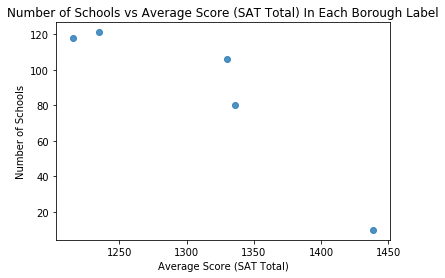

In [645]:
correlation(df,'Borough Label')

From the above table and graph, there appears to be a negative correlation between the number of schools within a borough and the corresponding mean Total SAT score. Let's further investigate this notion by assessing the correlation between cities and SAT scores.

### City and SAT Scores

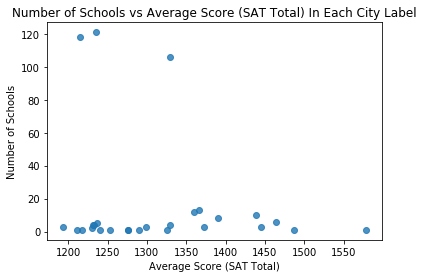

In [646]:
correlation(df,'City Label',print_table=False)

After further investigation, aside from a few outliers, there appears to be no distinct correlation between City and SAT Scores. Additionally, whilst there appear to be 3 cities that contain a significantly large number of schools, we cannot concede that there is a correlation between number of schools within a city and the corresponding mean SAT Score for that city.

### Zip Code and SAT Scores

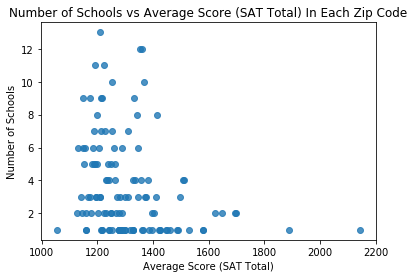

In [647]:
correlation(df,'Zip Code',print_table=False)

After analyzing the correlation between zip codes and total SAT scores, it appears that there is a negative correlation between the two. This notion lies in tandem with the correlation between Boroughs and SAT scores, however it may not strengthen this notion as zip codes and boroughs are related.

### Ethnicity Features and SAT Scores

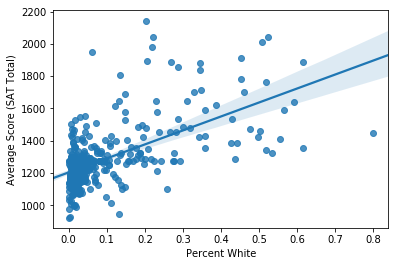

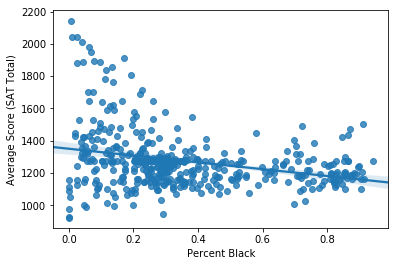

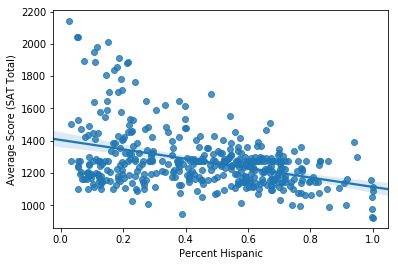

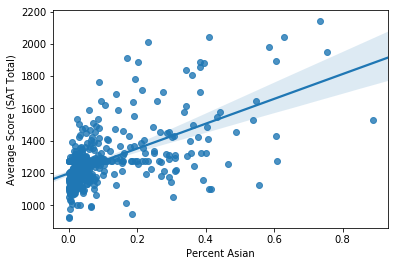

In [648]:
for col in ['Percent White','Percent Black','Percent Hispanic','Percent Asian']:
    sns.regplot(x=df[col], y=df["Average Score (SAT Total)"], fit_reg=True)
    plt.show()

At first glance, it appears that the percentage of White and Asian ethnicities within a school are positively correlated with the overall average SAT Score of that school. In contrast, the percentage of Black and Hispanic ethnities within a school are negatively correlated with the overall average SAT Scores of that school.

### Student Enrollment and SAT Scores

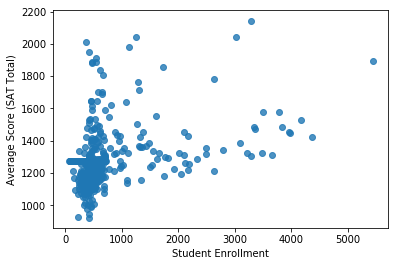

In [649]:
sns.regplot(x=df['Student Enrollment'].fillna(0), y=df['Average Score (SAT Total)'].fillna(0), fit_reg=False)
plt.show()

# Statistical Analysis
At this stage in the notebook, we will digress momentarily to perform a statistical analysis on various features to test the differences in SAT Scores between Boroughs. First, we will determine if the SAT Scores sample is normally distributed.

In [650]:
import scipy.stats as stats
t_test,pval = stats.normaltest(np.array(df['Average Score (SAT Total)']))
print(t_test,pval)
if pval < 0.05:
    print("Reject NULL hypothesis - Not Normally Distributed")
if pval > 0.05:
    print("Accept NULL hypothesis - Normally Distributed")

180.849569994 5.35814976626e-40
Reject NULL hypothesis - Not Normally Distributed


The data does not follow a normal distribution i.e. the ANOVA assumptions are violated deeming t-test hypothese approaches ineffective.

We should therefore use nonparametric tests such as the Mann Whitney U-test as it does not require the specific ANOVA assumptions to be met. 

In [651]:
print("Mann Whitney U test:")
column_list=['b0','b1','b2','b3','b4']
arrays=[np.array(['b0','b0','b1','b1','b2','b2','b3','b3','b4','b4']),
       np.array(['U-statistic','P-Value','U-statistic','P-Value',
                 'U-statistic','P-Value','U-statistic','P-Value','U-statistic','P-Value',])]
b0=[];b1=[];b2=[];b3=[];b4=[]
borough_list=[b0,b1,b2,b3,b4]
borough_series=pd.Series()
borough_df=pd.DataFrame(index=arrays)

for i in range(5):
    borough_list[i]=df.loc[df['Borough Label']==i,'Average Score (SAT Total)']

for i in range(5):
    temp_array = []
    for j in range(5):     
        U, pval = stats.mannwhitneyu(borough_list[i],borough_list[j])
        temp_array.append([U,pval])
    borough_series=pd.Series(np.ravel(temp_array), index=arrays)
    borough_df=pd.concat([borough_df, borough_series],axis=1)
borough_df.columns=column_list
borough_df

Mann Whitney U test:


b0            b1            b2            b3  \
b0 U-statistic  6.962000e+03  6.795500e+03  3.896500e+03  2.391500e+03   
   P-Value      4.996187e-01  2.602253e-01  5.355123e-07  1.870928e-09   
b1 U-statistic  6.795500e+03  7.320500e+03  4.529000e+03  2.875000e+03   
   P-Value      2.602253e-01  4.996335e-01  6.686575e-05  5.569665e-07   
b2 U-statistic  3.896500e+03  4.529000e+03  5.618000e+03  3.888000e+03   
   P-Value      5.355123e-07  6.686575e-05  4.995524e-01  1.663731e-01   
b3 U-statistic  2.391500e+03  2.875000e+03  3.888000e+03  3.200000e+03   
   P-Value      1.870928e-09  5.569665e-07  1.663731e-01  4.993184e-01   
b4 U-statistic  8.250000e+01  1.655000e+02  2.915000e+02  2.350000e+02   
   P-Value      3.237960e-06  7.038870e-05  9.516937e-03  1.726153e-02   

                        b4  
b0 U-statistic   82.500000  
   P-Value        0.000003  
b1 U-statistic  165.500000  
   P-Value        0.000070  
b2 U-statistic  291.500000  
   P-Value        0.009517  
b3 U-statistic  235.000000  
   P-Value        0.017262  
b4 U-statistic   50.000000  
   P-Value        0.484868

In [652]:
borough_df=borough_df.drop('U-statistic', axis=0, level=1)
borough_df>=0.05

,,b0,b1,b2,b3,b4
b0,P-Value,True,True,False,False,False
b1,P-Value,True,True,False,False,False
b2,P-Value,False,False,True,True,False
b3,P-Value,False,False,True,True,False
b4,P-Value,False,False,False,False,True


From the above we can determine which boroughs are statistically similar. With a p-value greater than 0.05, Boroughs 0 and 1 are similar and Boroughs 2 and 3 are similar.

# Model Selection
We now have a complete dataset ready to train and test models. We understand the problem domain as well as all the features included in the dataset. In order to select the appropriate predictive modelling techniques, we must first understand the type of problem. <br><br>
In our instance, we want to identify the relationship between SAT scores and other features including location (e.g. Borough), ethnicity (e.g. Percent White) and number of students (e.g. Student Enrollment). It is clear that this problem involved classification and regression applications. Furthermore, we are breaking the dataset into training and testing data, therefore this will be a supervised learning approach to machine learning. <br><br>
Combining Classification and Regression applications with Supervised Learning, the approriate models that we will select are:
- Random Forest Regressor,
- Support Vector Machines (SVC)
- Decision Tree Classifier
- Linear SVC
- Naive Bayes Classifier
- k-Nearest Neighbors (KNN)
- Random Forest Classifier
- Logistic Regression

In [653]:
features=['Percent White','Percent Black','Percent Hispanic','Percent Asian','Percent Tested']

In [654]:
df[features]=df[features]*100

In [655]:
df=df.astype(int)

In [656]:
def rmse_func(model,X_train,X_results,Y_train,Y_results):
    model.fit(X_train, X_results)
    predictions = model.predict(Y_train)
    acc_model = round(accuracy_score(Y_results, predictions)*100,2)
    rmse = np.sqrt(mean_squared_error(Y_results, predictions))   
    return acc_model,rmse

In [744]:
#Set Features To Drop
features = []
# features.append('Start Time Rank')
# features.append('End Time Rank')
# features.append('Borough Label')
# features.append('Zip Code')
# features.append('City Label')
# features.append('Student Enrollment')
# features.append('Average Score (SAT Math)')
# features.append('Average Score (SAT Reading)')
# features.append('Average Score (SAT Writing)')
# features.append('Percent Tested')
# features.append('Average Score (SAT Total)')
features.append('Percent White')
features.append('Percent Black')
features.append('Percent Hispanic')
features.append('Percent Asian')

In [745]:
# Categorize the Average Scores into bands for Classification
df.loc[df['Average Score (SAT Total)']<970,'Bands']=12 #'F'
df.loc[df['Average Score (SAT Total)'].between(970,1030),'Bands']=11 #'D'
df.loc[df['Average Score (SAT Total)'].between(1030,1070),'Bands']=10 #'D+'
df.loc[df['Average Score (SAT Total)'].between(1070,1120),'Bands']=9 #'C-'
df.loc[df['Average Score (SAT Total)'].between(1120,1200),'Bands']=8 #'C'
df.loc[df['Average Score (SAT Total)'].between(1200,1260),'Bands']=7 #'C+'
df.loc[df['Average Score (SAT Total)'].between(1260,1330),'Bands']=6 #'B-'
df.loc[df['Average Score (SAT Total)'].between(1330,1440),'Bands']=5 #'B'
df.loc[df['Average Score (SAT Total)'].between(1440,1550),'Bands']=4 #'B+'
df.loc[df['Average Score (SAT Total)'].between(1550,1600),'Bands']=3 #'A-'
df.loc[df['Average Score (SAT Total)'].between(1600,1870),'Bands']=2 #'A'
df.loc[df['Average Score (SAT Total)']>=1870,'Bands']=1 #'A+'

In [746]:
# Automatically Split-out validation dataset
X = pd.DataFrame(df[features].values)
Y = pd.DataFrame(df['Bands'])
validation_size = 0.7
seed = 5
X_train, Y_train, X_results, Y_results = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [747]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_results = np.array(X_results)
Y_results = np.array(Y_results)

In [748]:
model_column=['Model Accuracy %','RMSE']
model_list=[SVC(),
            DecisionTreeClassifier(),
            GaussianNB(),
            KNeighborsClassifier(n_neighbors = 3),
            RandomForestClassifier(n_estimators=100),
            LogisticRegression()
           ]

model_df=(pd.DataFrame(data=list(map(lambda model:rmse_func(model,X_train,X_results.ravel(),Y_train,Y_results),model_list)),
             index=map(lambda x: x.__class__.__name__, model_list),
             columns=model_column).sort_values(by=model_column[0], ascending=False))
model_df

,Model Accuracy %,RMSE
LogisticRegression,32.79,1.746190
GaussianNB,30.49,1.648646
SVC,27.87,1.863366
RandomForestClassifier,24.92,1.855431
KNeighborsClassifier,22.95,2.099180
DecisionTreeClassifier,21.64,2.055780


### Results

Whilst these results are less than satisfactory, this exercise proves useful as a basic introduction into understanding the methods involved in cleaning a dataset in order to perform machine learning analysis. With further feature engineering, the results of these models could be improved.